<a href="https://colab.research.google.com/github/ancientpi3/Fellowship2022/blob/main/FER13_GAN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import drive
from google.colab import files
from zipfile import ZipFile
import cv2
import os

In [ ]:
drive.mount('/content/gdrive')

filename2 = "/content/gdrive/MyDrive/archive_2x.zip"
filename = "/content/gdrive/MyDrive/archive.zip"
with ZipFile(filename, "r",) as zip:
  zip.extractall(path="/content/emotion_data_reduced")
with ZipFile(filename2, "r",) as zip:
  zip.extractall(path="/content/2x_emotion_data_reduced")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
instances = []
directory = "/content/emotion_data_reduced/train/happy"
# Load in the images
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
      instances.append(cv2.resize(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY),(48,48)))
x_train = np.array(instances).reshape(7215, 48, 48, 1)
x_train = x_train / 255.0

In [ ]:
x_train.shape

(7215, 48, 48, 1)

In [ ]:
def discriminator():
  discriminator_input = keras.Input(shape=(48,48,1),name="d_input")
  x = keras.layers.Conv2D(128,(3,3),strides = (2,2),padding = "same", activation="relu")(discriminator_input)
  x = keras.layers.Conv2D(128,(3,3),strides = (1,1),padding = "same", activation="relu")(x)
  x = keras.layers.Conv2D(128,(3,3),strides = (2,2),padding = "same", activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(50)(x)
  x = keras.layers.Dropout(rate=.3)(x)
  discriminator_output = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(discriminator_input, discriminator_output,name="discriminator")
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
def generator(latent_dim=256):
  generator_input = keras.Input(shape=(latent_dim),name="g_input")
  n_nodes = 6*6*128
  x = keras.layers.Dense(200)(generator_input)
  x = keras.layers.Dropout(rate=.5)(x)
  x = keras.layers.Dense(n_nodes)(x)
  x = keras.layers.Reshape((6,6,128))(x)
  x = keras.layers.Dropout(rate=.5)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  generator_output = keras.layers.Conv2D(1,(7,7),padding="same",activation="sigmoid")(x)
  return keras.Model(generator_input, generator_output,name="generator")

In [ ]:
d_model = discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 dropout (Dropout)           (None, 12, 12, 128)       0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 50)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
g_model = generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 g_input (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 200)               51400     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 4608)              926208    
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      14

In [ ]:
def GAN(d_model,g_model):
	d_model.trainable = False
	model = keras.models.Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
GAN_model = GAN(d_model,g_model)
GAN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 48, 48, 1)         1426633   
                                                                 
 discriminator (Functional)  (None, 1)                 1218149   
                                                                 
Total params: 2,644,782
Trainable params: 1,426,633
Non-trainable params: 1,218,149
_________________________________________________________________


In [ ]:
def grab_real_batch(x_train, batch_size):
	ix = np.random.randint(0, x_train.shape[0], batch_size)
	X = x_train[ix]
	#y = np.ones((batch_size, 1))
	return X

In [ ]:
def grab_fake_batch(g_model,batch_size, latent_dim=256):
  latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
  predictions = g_model.predict(latent_points,verbose=0)
  return predictions

In [ ]:
def save_plot(examples, epoch, n=10):
	for i in range(50):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
def train(d_model,g_model,gan_model, x_train, epochs=150, verbose=1):
  latent_dim = 256
  batch_size = 32
  batches_per_epoch = 50
  save_plot(grab_fake_batch(g_model,50).reshape(50,48,48,1),epoch=0)
  for epoch in range(epochs):
    print("Epoch: ",epoch)
    for _ in range(batches_per_epoch):
      d_model.trainable = True
      #print("training discriminator on real batch")
      real_batch = grab_real_batch(x_train, batch_size)
      d_model.fit(x=real_batch, y = np.ones(batch_size),verbose=verbose)
      #print("training discriminator on fake batch")
      fake_batch = grab_fake_batch(g_model, batch_size)
      d_model.fit(x=fake_batch, y = np.zeros(batch_size),verbose=verbose)

      d_model.trainable = False
      #print("training GAN on fake batch with real label to measure how well G fools D")
      latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
      gan_model.fit(x=latent_points, y=np.ones(batch_size),verbose=verbose)
    if(epoch%20==19):
      save_plot(grab_fake_batch(g_model,50).reshape(50,48,48,1),epoch=epoch)

In [ ]:
save_plot(grab_real_batch(x_train,50).reshape(50,48,48,1),epoch=-1)

In [ ]:
train(d_model,g_model, GAN_model,x_train, verbose=0)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

KeyboardInterrupt: ignored

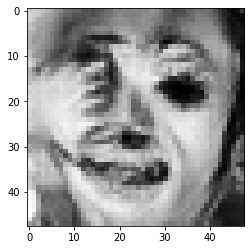

In [ ]:
results = grab_fake_batch(g_model,5)
plt.imshow(results[3].reshape(48,48), cmap="gray")

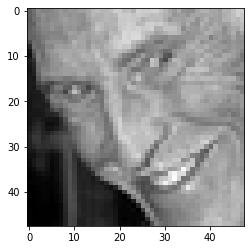

In [ ]:
results = grab_real_batch(x_train,5)
plt.imshow(results[3].reshape(48,48), cmap="gray")

In [ ]:
g_model.save("fer13_g_model_v1.h5")